# Prediction of Obesity Risk - Modelling

## Problem Statement

# Import Libraries

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x:'%.3f' % x)
import numpy as nb
import matplotlib.pyplot as plt
import seaborn as sb
# Configure default settings for plots
sb.set(style='ticks')
sb.set_palette('Paired')
plt.rcParams['axes.spines.top'] = False    # Remove top border
plt.rcParams['axes.spines.right'] = False  # Remove right border

# Load Data

In [57]:
data = pd.read_csv('../Data/Processed/processed_with_outliers.csv')
print(f'Dataset has {data.shape[0]} rows and {data.shape[1]} columns')

Dataset has 20758 rows and 17 columns


In [58]:
# Creating a copy of the dataset in memory in case of misediting
df = data.copy()

# Data Preprocessing

In [59]:
# Create lists for categorical and numeric columns
cat_cols = []
num_cols = []

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        num_cols.append(column)
    elif pd.api.types.is_object_dtype(df[column]):
        cat_cols.append(column)
        
print(f'Categorical columns: {len(cat_cols)}', cat_cols)
print(f'Numeric columns: {len(num_cols)}', num_cols)

Categorical columns: 9 ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']
Numeric columns: 8 ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


In [60]:
cat_features = cat_cols[:-1]
print(cat_features)
print(cat_cols)

['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']


In [61]:
from sklearn.preprocessing import LabelEncoder

In [62]:
lbl_encoder = LabelEncoder()
df['NObeyesdad'] = lbl_encoder.fit_transform(df['NObeyesdad'])
df['NObeyesdad'].value_counts()

4    4046
3    3248
1    3082
2    2910
0    2523
6    2522
5    2427
Name: NObeyesdad, dtype: int64

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Split the Dataset

In [64]:
x = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

## Transform Data

In [71]:
# Define transformers for different column types
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# Combine transformers for specific columns
preprocessor = ColumnTransformer([
    ("num", numerical_transformer, num_cols),
    ("cat", categorical_transformer, cat_features)
])

# Fit transformers on training data only
preprocessor.fit(x_train)

# Transform train and test data using fitted transformers
x_train_transformed = preprocessor.transform(x_train)
x_test_transformed = preprocessor.transform(x_test)


/opt/anaconda3/envs/cloneTF2/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Evaluating Different Algorithms

In this section we'll evaluate non-linear and ensemble algorithms using k-fold cross validation.

In [29]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

In [46]:
def model_evaluation(x, y, models):
    '''
        This function takes x, y and models and applies 
        k-fold cross validation to the each algorithm in 
        the models list by using x and y training set. 
        Displays the mean and standard deviation of 
        accuracy, precision, recall, f1 scores in tabular
        format and boxplots.

        ---
        ### Parameters
        - x <array>: Feature values.
        - y <array>: Target values.
        - models <list>: List of the model objects to be vealuated.
    '''
    
    names = []
    scoring = ['accuracy']
    
    # Create a dataframe to store the different metric values for each algorithm
    df_results = pd.DataFrame(columns=['Algorithm', 'Acc Mean', 'Acc STD'])
    results_acc = [] # List of accuracy scores for each fold of each algorithm
    
    for name, model in models:
        names.append(name)
        kfold = KFold(n_splits=10, shuffle=True, random_state=101)
        result = cross_validate(model, x, y, cv=kfold, scoring=scoring)
    
        # Mean and standard deviation of Accuracy scores for the algorithm
        acc_mean = result['test_accuracy'].mean()
        acc_std = result['test_accuracy'].std()
        
        # Create the row of the results
        df_result_row = {'Algorithm': name, 'Acc Mean': acc_mean, 'Acc STD': acc_std}
        # Add the row to the results data frame
        df_results = pd.concat([df_results, pd.DataFrame([df_result_row])], ignore_index=True)
        
        results_acc.append(result['test_accuracy'])
        
    df_results = df_results.set_index('Algorithm')
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    # Display the mean and standard deviation of all metrics for all algorithms
    print(df_results)
    
    # Display the overall results in a boxplot graph
    width = (len(models)*2)
    plot_objects = plt.subplots(nrows=1, ncols=1, figsize=(width, 6))
    fig, ax = plot_objects
    
    ax.boxplot(results_acc)
    ax.set_title('Accuracy', fontsize=14)
    ax.set_xticklabels(names, rotation=30)
    plt.tight_layout()
    plt.show()

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [32]:
ens_models = []
ens_models.append(('RFC', RandomForestClassifier()))
ens_models.append(('ABC', AdaBoostClassifier()))
ens_models.append(('GBC', GradientBoostingClassifier()))

           Acc Mean  Acc STD
Algorithm                   
RFC           0.892    0.009
ABC           0.437    0.067
GBC           0.906    0.006


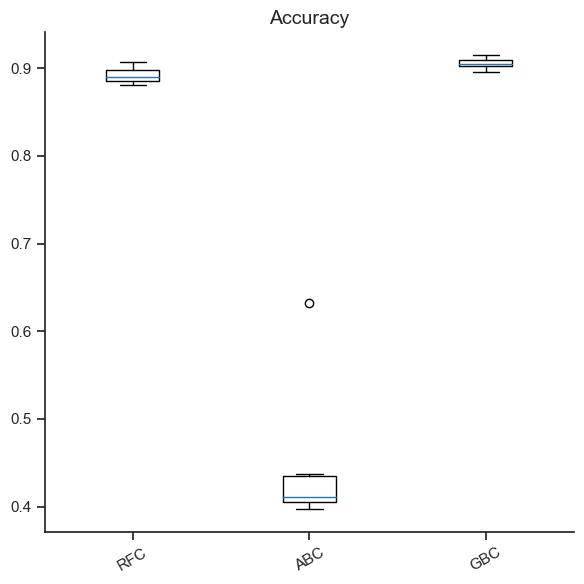

In [73]:
model_evaluation(x_train_transformed, y_train, ens_models)

In [42]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

           Acc Mean  Acc STD
Algorithm                   
SVC           0.877    0.005
DTC           0.847    0.008
KNN           0.755    0.009
GNB           0.614    0.012


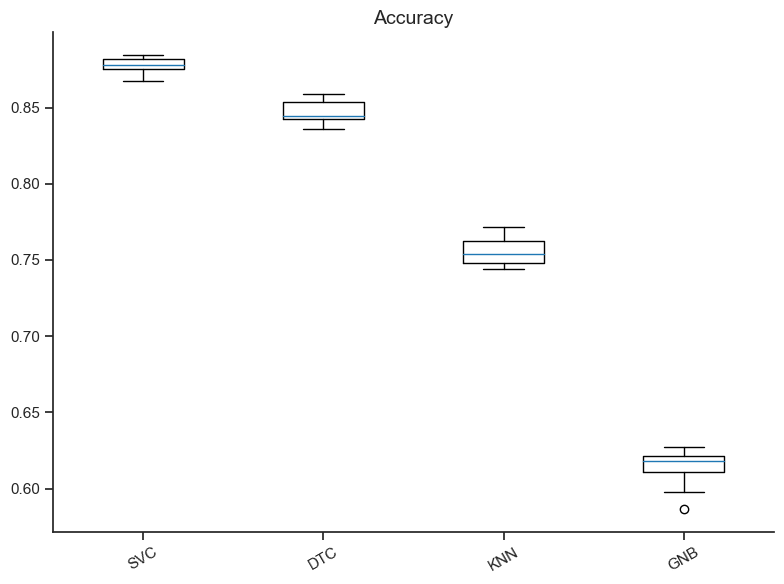

In [74]:
nl_models = []
nl_models.append(('SVC', SVC()))
nl_models.append(('DTC', DecisionTreeClassifier()))
nl_models.append(('KNN', KNeighborsClassifier()))
nl_models.append(('GNB', GaussianNB()))

model_evaluation(x_train_transformed, y_train, nl_models)

# Next Steps

- Modelling